Этот ноутбук посвящен подбору оптимальных параметров функции отклика. С одной стороны, функция отклика должна порождать набор откликов, который был бы схож по распределению к исходным откликам. С другой стороны, функция отклика должна порождать такой набор откликов, качество рекомендательной системы на котором было бы близко к качеству рекомендательной системы на реальных данных. Поэтому была предложена следующая целевая функция для отыскания оптимальных параметров функции отклика:
$$KS(\alpha_1,\alpha_2,\ldots,\alpha_n)+KL(\alpha_1,\alpha_2,\ldots,\alpha_n)-\sum_{i=1}^{N}|QM_{syn}^i(\alpha_1,\alpha_2,\ldots,\alpha_n)-QM_{real}^i|\rightarrow\ {max}_{\alpha_1,\alpha_2,\ldots,\alpha_n},$$
где $\alpha_1,\alpha_2,\ldots,\alpha_n$ -- параметры функции отклика, $KS(\alpha_1,\alpha_2,\ldots,\alpha_n)$ -- единица минус значение статистики Колмогорова-Смирнова между двумя распределениями, $KL(\alpha_1,\alpha_2,\ldots,\alpha_n)$ -- нормированное значение расстояния Кульбака-Лейблера.

В данном эксперименте были использованы такие метрики качества, значения которых находятся в промежутке $[0;1],$ поэтому значения целевой функции лежат в диапазоне $[-1; 2].$

Эксперимент проводится на валидационном датасете, в рамках которого происходит обучение рекомендательной системы с помощью симулятора на искусственно сгенерированных данных.

Профили пользователей генерируются из распределения N(1,1); половина предложений генерируется из распределения N(-1, 1), другая половина -- из распределения N(1, 1). Отклики формируются как скалярное произведение профиля пользователя и профиля предложения, бинаризованное по порогу 0.5.

In [8]:
import warnings
warnings.filterwarnings("ignore")

import random
import time
import itertools
import math

import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import PipelineModel
from pyspark.sql.functions import rand 
import pyspark.sql.types as st
import pyspark.sql.functions as sf

from replay.session_handler import State
from replay.metrics import NDCG, Precision, RocAuc
from replay.data_preparator import Indexer

from simulator.utils import pandas_to_spark
from simulator.modules import SDVDataGenerator, RealDataGenerator
from simulator.modules import evaluate_synthetic
from simulator.modules import Simulator
from simulator.modules import EvaluateMetrics
from simulator.utils import VectorElementExtractor
from simulator.response import NoiseResponse, CosineSimilatiry
from simulator.response import ParametricResponseFunction, BernoulliResponse
from simulator.modules import QualityControlObjective

from transformers import ModelCalibration

from ucb import UCB

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity

spark = SparkSession.builder\
    .appName('simulator_validation')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '32g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')
State(spark)

In [134]:
CHECKPOINTS_DIR='/data/home/estavinova/tmp/checkpoints/validation_quality'
CHECKPOINTS_DIR2='/data/home/estavinova/tmp/checkpoints/validation_quality_real'
CHECKPOINTS_DIR3='/data/home/estavinova/tmp/checkpoints/validation_quality_opt'
tmp_path = '/data/home/estavinova/tmp/models/'
data_path = '/data/home/estavinova/simulator/'

In [74]:
users_df = pd.DataFrame(data=np.random.normal(1, 1, size=(10000, 35)), columns=[f'user_attr_{i}' for i in range(35)]) 
items_df = pd.DataFrame(data=np.random.normal(-1, 1, size=(2000, 35)), columns=[f'item_attr_{i}' for i in range(35)]) 
items_df.loc[random.sample(range(2000), 1000)] = np.random.normal(1, 1, size=(1000, 35))
users_df['user_id'] = np.arange(len(users_df))
items_df['item_id'] = np.arange(len(items_df))
history_df_all = pd.DataFrame()

history_df_all['user_id'] = [i[0] for i in itertools.product(np.arange(10000), np.arange(2000))]
history_df_all['item_id'] = [i[1] for i in itertools.product(np.arange(10000), np.arange(2000))]
history_df_all['relevance'] = 0

users_matrix = users_df.values[history_df_all.values[:, 0], :-1]
items_matrix = items_df.values[history_df_all.values[:, 1], :-1]
dot = np.sum(users_matrix * items_matrix, axis=1)
den = np.linalg.norm(users_matrix, ord=2, axis=1) * np.linalg.norm(items_matrix, ord=2, axis=1)
cosine = dot / den
similarity = 1 - np.arccos(cosine) / math.pi

history_df_all['relevance'] = np.where(np.random.random(len(similarity)) <= similarity, 1, 0)
history_df_all['timestamp'] = 0
history_df_all = history_df_all.drop_duplicates(subset=['user_id', 'item_id'], ignore_index=True)

history_df_train = history_df_all.sample(frac = 0.1).reset_index(drop=True)
history_df_val = pd.concat([history_df_all, history_df_train]).\
    drop_duplicates(subset=['user_id', 'item_id'], keep=False, ignore_index=True).\
    sample(frac = 0.33).reset_index(drop=True)

users_df = pandas_to_spark(users_df)
items_df = pandas_to_spark(items_df)
history_df_train = pandas_to_spark(history_df_train)
history_df_val = pandas_to_spark(history_df_val)
history_df_all = pandas_to_spark(history_df_all)

In [75]:
history_df_train.write.option("header",True).csv(data_path+"history_df_train_spoiled.csv")
history_df_val.write.option("header",True).csv(data_path+"history_df_val_spoiled.csv")
history_df_all.write.option("header",True).csv(data_path+"history_df_all_spoiled.csv")

# Synthetic data generation

На искусственно сгенерированных профилях пользователей обучается модель GaussianCopula для генерации синтетических профилей.

In [76]:
%%time
user_generator = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    seed=1234
)

item_generator = RealDataGenerator(
    label='real',
    seed=1234
)

user_generator.fit(users_df.drop('user_id'))

item_generator.fit(items_df)

syn_users = user_generator.generate(10000)
gen_score = evaluate_synthetic(syn_users.drop('user_id'), users_df.drop('user_id'))
print(gen_score)

{'LogisticDetection': 1.0, 'SVCDetection': 0.9156414228204114, 'KSTest': 0.9893685714285712, 'ContinuousKLDivergence': 0.9846094056449105}
CPU times: user 4min, sys: 7.25 s, total: 4min 7s
Wall time: 4min 9s


In [9]:
user_generator.save_model(f'{tmp_path}/validation_gaussiancopula.pkl')

In [77]:
real_user_generator = RealDataGenerator(
    label='real',
    seed=1234
)

real_user_generator.fit(users_df)

In [94]:
sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR,
)

evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

In [79]:
sim_real = Simulator(
    user_gen=real_user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR2,
)

# Response function

Синтетическая функция отклика представляет собой случайную величину из распределения Бернулли, вероятность успеха которого определяется трехкомпонентной комбинацией:
$$f_{syn}(u_i, m_j)=Ber(\alpha_1Heur(u_i,m_j)+\alpha_2Real(u_i,m_j)+\alpha_3Random(u_i,m_j)),$$
$$\alpha_1+\alpha_2+\alpha_3=1; \alpha_1,\alpha_2,\alpha_3\in[0,1],$$
$$\forall u_i\in U_{syn}; \forall m_j \in M,$$
где $u_i$ –- вектор атрибутов пользователя, $m_j$ –- вектор атрибутов предложения, $U_{syn}$ –- набор синтетических профилей пользователей, $M$ –- набор профилей предложений, $Heur$ -– это эвристическая компонента (основанная на предположении о полезности действия пользователя), $Real$ –- компонента, которая моделирует отклик в наборе данных реального мира, $Random$ -– случайная компонента.

In [80]:
%%time
va = VectorAssembler(
    inputCols=users_df.columns[:-1] + items_df.columns[:-1],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)

train_df = history_df_train.join(users_df, 'user_id', 'left')\
                       .join(items_df, 'item_id', 'left')\
                       .drop('timestamp')

lr_model = lr.fit(va.transform(train_df))

CPU times: user 92.5 ms, sys: 26.4 ms, total: 119 ms
Wall time: 35.9 s


In [81]:
test_df = history_df_val.join(users_df, 'user_id', 'left')\
                        .join(items_df, 'item_id', 'left')\
                        .drop('timestamp')

pred_df = vee.transform(lr_model.transform(va.transform(test_df))).select("user_id", "item_id", "relevance", "__r1").toPandas()

print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.6774498811158217


В целях демонстрации была выбрана функция отклика, состоящая из реалистичной и шумовой компоненты (с коэффициентами 0.5).

In [95]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='__r2', seed=1234)
va_users = VectorAssembler(
    inputCols=users_df.columns[:-1],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=items_df.columns[:-1],
    outputCol='features_itm'
)

cos_sim = CosineSimilatiry(
    inputCols=["features_usr", "features_itm"],
    outputCol="__r3"
)
resp_func = ParametricResponseFunction(
    inputCols=['__r1', '__r2', '__r3'],
    outputCol='__proba',
    weights=[0.5, 0.5, 0.0]
)

br = BernoulliResponse(inputCol='__proba', outputCol='response', seed=1234)


pipeline = PipelineModel(
    stages=[
        va,
        lr_model,
        vee,
        noise_resp,
        va_users,
        va_items,
        cos_sim,
        resp_func,
        br
    ]
)

In [96]:
%%time
real_indexer = Indexer(user_col='user_id', item_col='item_id')
real_indexer.fit(users=users_df, items=items_df)

synth_indexer = Indexer(user_col='user_id', item_col='item_id')
synth_indexer.fit(users=user_generator.sample(1.0), items=items_df)

real_model = UCB(sample = True)
simulator_model = UCB(sample = True)

real_model.fit(log=real_indexer.transform(history_df_train.drop('timestamp').limit(1)))
simulator_model.fit(log=synth_indexer.transform(history_df_train.drop('timestamp').limit(1)))

CPU times: user 669 ms, sys: 245 ms, total: 914 ms
Wall time: 4.84 s


# Real model training

Обучаем модель UCB на реальных данных, но с использованием методологии обучения рекомендательной системы в симуляторе.

In [84]:
%%time

ndcg = NDCG()
precision = Precision()

LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

real_learning_metrics = []
items_replay = real_indexer.transform(items_df).cache()

for i in range(20):
    print(f'Stage {i}')
    start_iter = time.time()
    log = sim_real.log
    if log is None:
        log = empty_log
    log = log.cache()
    users = users_df.sample(0.02).cache()

    recs = real_model.predict(
        log=real_indexer.transform(log),
        k=10,
        users=real_indexer.transform(users),
        items=items_replay
    )
    recs = real_indexer.inverse_transform(recs).cache()
    
    true_resp = history_df_all.withColumnRenamed('relevance', 'response')\
        .join(recs, on=['user_id', 'item_id'], how='inner').drop('timestamp').cache()
    
    sim_real.update_log(true_resp, iteration=i)
    
    real_learning_metrics.append(evaluator(true_resp))

    real_model._clear_cache()
    train_log = sim_real.log.cache()
    real_model.fit(
        log=real_indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )
        
    users.unpersist()
    train_log.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    end_iter = time.time()
    print(f"Time of {i} iteration: ")
    print(end_iter - start_iter)

log = sim_real.log.cache()
users = users_df.sample(0.2).cache()

real_recs = real_model.predict(
    log=real_indexer.transform(log),
    k=10,
    users=real_indexer.transform(users),
    items=items_replay
)
real_recs = real_indexer.inverse_transform(real_recs).cache()

real_ground_truth = history_df_all.withColumnRenamed('relevance', 'response')\
    .join(real_recs, on=['user_id', 'item_id'], how='inner').drop('timestamp').cache()

real_final_metrics = evaluator(real_ground_truth)

items_replay.unpersist()

Stage 0


Time of 0 iteration: 
24.15433955192566
Stage 1


Time of 1 iteration: 
20.431910037994385
Stage 2


Time of 2 iteration: 
18.729608058929443
Stage 3


Time of 3 iteration: 
17.287887811660767
Stage 4


Time of 4 iteration: 
19.051512241363525
Stage 5


Time of 5 iteration: 
17.81776785850525
Stage 6


Time of 6 iteration: 
19.837247848510742
Stage 7


Time of 7 iteration: 
17.767375469207764
Stage 8


Time of 8 iteration: 
18.321730852127075
Stage 9


Time of 9 iteration: 
17.88185954093933
Stage 10


Time of 10 iteration: 
19.169301986694336
Stage 11


Time of 11 iteration: 
18.224119901657104
Stage 12


Time of 12 iteration: 
21.889883995056152
Stage 13


Time of 13 iteration: 
17.67685341835022
Stage 14


Time of 14 iteration: 
19.16236400604248
Stage 15


Time of 15 iteration: 
16.960163831710815
Stage 16


Time of 16 iteration: 
19.802045345306396
Stage 17


Time of 17 iteration: 
16.938894987106323
Stage 18


Time of 18 iteration: 
19.098435163497925
Stage 19


Time of 19 iteration: 
19.642553567886353


CPU times: user 17.9 s, sys: 4.41 s, total: 22.3 s
Wall time: 6min 36s


DataFrame[item_attr_0: double, item_attr_1: double, item_attr_2: double, item_attr_3: double, item_attr_4: double, item_attr_5: double, item_attr_6: double, item_attr_7: double, item_attr_8: double, item_attr_9: double, item_attr_10: double, item_attr_11: double, item_attr_12: double, item_attr_13: double, item_attr_14: double, item_attr_15: double, item_attr_16: double, item_attr_17: double, item_attr_18: double, item_attr_19: double, item_attr_20: double, item_attr_21: double, item_attr_22: double, item_attr_23: double, item_attr_24: double, item_attr_25: double, item_attr_26: double, item_attr_27: double, item_attr_28: double, item_attr_29: double, item_attr_30: double, item_attr_31: double, item_attr_32: double, item_attr_33: double, item_attr_34: double, item_idx: int]

In [85]:
real_final_metrics

{'NDCG@10': 0.84350353159632,
 'Precision@10': 0.5578178275694103,
 'RocAuc@10': 0.6200580644662476}

# Synthetic model training (in simulator)

Как и в предыдущих экспериментах, обучаем модель UCB с помощью симулятора на синтетических данных.

In [97]:
LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

items_replay = synth_indexer.transform(items_df).cache()

ucb_metrics_old = []

for i in range(20):
    iter_start = time.time()

    users = sim.sample_users(0.02).cache()
    
    log = sim.get_log(users)
    if log is None:
        log = empty_log
    log = log.cache()

    recs_ucb = simulator_model.predict(
        log=synth_indexer.transform(log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
    recs_ucb = synth_indexer.inverse_transform(recs_ucb).cache()

    resp_ucb = sim.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items_df,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    sim.update_log(resp_ucb, iteration=i)

    ucb_metrics_old.append(evaluator(resp_ucb))

    simulator_model._clear_cache()
    ucb_train_log = sim.log.cache()
    simulator_model.fit(
        log=synth_indexer.transform(
            ucb_train_log\
                .select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    resp_ucb.unpersist()
    ucb_train_log.unpersist()

    print(f'Iteration {i} finished with time {time.time() - iter_start} sec.')
    
users = sim.sample_users(0.2).cache()
synth_recs = synth_indexer.inverse_transform(
    simulator_model.predict(
        log=synth_indexer.transform(sim.log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
).cache()
synth_ground_truth = sim.sample_responses(
    recs_df=synth_recs,
    user_features=users,
    item_features=items_df,
    action_models=pipeline
).select('user_id', 'item_id', 'relevance', 'response').cache()
final_metrics = evaluator(synth_ground_truth)

items_replay.unpersist()

Iteration 0 finished with time 16.273345232009888 sec.


Iteration 1 finished with time 12.77390456199646 sec.
Iteration 2 finished with time 10.9720458984375 sec.


Iteration 3 finished with time 11.906293153762817 sec.


Iteration 4 finished with time 12.510987997055054 sec.
Iteration 5 finished with time 12.265539407730103 sec.


Iteration 6 finished with time 13.741250276565552 sec.


Iteration 7 finished with time 11.896373748779297 sec.


Iteration 8 finished with time 12.24850845336914 sec.


Iteration 9 finished with time 13.451990365982056 sec.


Iteration 10 finished with time 13.439898490905762 sec.


Iteration 11 finished with time 13.904045104980469 sec.


Iteration 12 finished with time 12.722561597824097 sec.


Iteration 13 finished with time 13.27617073059082 sec.


Iteration 14 finished with time 13.161933183670044 sec.


Iteration 15 finished with time 12.761510372161865 sec.
Iteration 16 finished with time 13.232937574386597 sec.


Iteration 17 finished with time 13.861734867095947 sec.


Iteration 18 finished with time 13.172895908355713 sec.


Iteration 19 finished with time 14.509940147399902 sec.


DataFrame[item_attr_0: double, item_attr_1: double, item_attr_2: double, item_attr_3: double, item_attr_4: double, item_attr_5: double, item_attr_6: double, item_attr_7: double, item_attr_8: double, item_attr_9: double, item_attr_10: double, item_attr_11: double, item_attr_12: double, item_attr_13: double, item_attr_14: double, item_attr_15: double, item_attr_16: double, item_attr_17: double, item_attr_18: double, item_attr_19: double, item_attr_20: double, item_attr_21: double, item_attr_22: double, item_attr_23: double, item_attr_24: double, item_attr_25: double, item_attr_26: double, item_attr_27: double, item_attr_28: double, item_attr_29: double, item_attr_30: double, item_attr_31: double, item_attr_32: double, item_attr_33: double, item_attr_34: double, item_idx: int]

In [98]:
final_metrics

{'NDCG@10': 0.7932256245986999,
 'Precision@10': 0.5165770171149142,
 'RocAuc@10': 0.5444755501222496}

Проверим на реальных данных качество рексистемы, обученной на синтетике.

In [99]:
items_replay = real_indexer.transform(items_df).cache()
log = sim.log.cache()
users = users_df.sample(0.02).cache()

real_recs = simulator_model.predict(
    log=synth_indexer.transform(log),
    k=10,
    users=real_indexer.transform(users),
    items=items_replay
)
real_recs = real_indexer.inverse_transform(real_recs).cache()

real_ground_truth = history_df_all.withColumnRenamed('relevance', 'response')\
    .join(real_recs, on=['user_id', 'item_id'], how='inner').drop('timestamp').cache()

real_metrics_trained_on_synth = evaluator(real_ground_truth)
items_replay.unpersist()

DataFrame[item_attr_0: double, item_attr_1: double, item_attr_2: double, item_attr_3: double, item_attr_4: double, item_attr_5: double, item_attr_6: double, item_attr_7: double, item_attr_8: double, item_attr_9: double, item_attr_10: double, item_attr_11: double, item_attr_12: double, item_attr_13: double, item_attr_14: double, item_attr_15: double, item_attr_16: double, item_attr_17: double, item_attr_18: double, item_attr_19: double, item_attr_20: double, item_attr_21: double, item_attr_22: double, item_attr_23: double, item_attr_24: double, item_attr_25: double, item_attr_26: double, item_attr_27: double, item_attr_28: double, item_attr_29: double, item_attr_30: double, item_attr_31: double, item_attr_32: double, item_attr_33: double, item_attr_34: double, item_idx: int]

In [100]:
real_metrics_trained_on_synth

{'NDCG@10': 0.8100318174258643,
 'Precision@10': 0.5275862068965518,
 'RocAuc@10': 0.5729011259676284}

И наоборот: проверим на синтетических данных качество рексистемы, обученной на реальных.

In [90]:

items_replay = real_indexer.transform(items_df).cache()
users = sim.sample_users(0.02).cache()
synth_recs = synth_indexer.inverse_transform(
    real_model.predict(
        log=real_indexer.transform(sim_real.log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
).cache()
synth_ground_truth = sim.sample_responses(
    recs_df=synth_recs,
    user_features=users,
    item_features=items_df,
    action_models=pipeline
).select('user_id', 'item_id', 'relevance', 'response').cache()
synth_metrics_trained_on_real = evaluator(synth_ground_truth)
items_replay.unpersist()

DataFrame[item_attr_0: double, item_attr_1: double, item_attr_2: double, item_attr_3: double, item_attr_4: double, item_attr_5: double, item_attr_6: double, item_attr_7: double, item_attr_8: double, item_attr_9: double, item_attr_10: double, item_attr_11: double, item_attr_12: double, item_attr_13: double, item_attr_14: double, item_attr_15: double, item_attr_16: double, item_attr_17: double, item_attr_18: double, item_attr_19: double, item_attr_20: double, item_attr_21: double, item_attr_22: double, item_attr_23: double, item_attr_24: double, item_attr_25: double, item_attr_26: double, item_attr_27: double, item_attr_28: double, item_attr_29: double, item_attr_30: double, item_attr_31: double, item_attr_32: double, item_attr_33: double, item_attr_34: double, item_idx: int]

In [91]:
synth_metrics_trained_on_real

{'NDCG@10': 0.8282097179517367,
 'Precision@10': 0.548087431693989,
 'RocAuc@10': 0.5748456067308527}

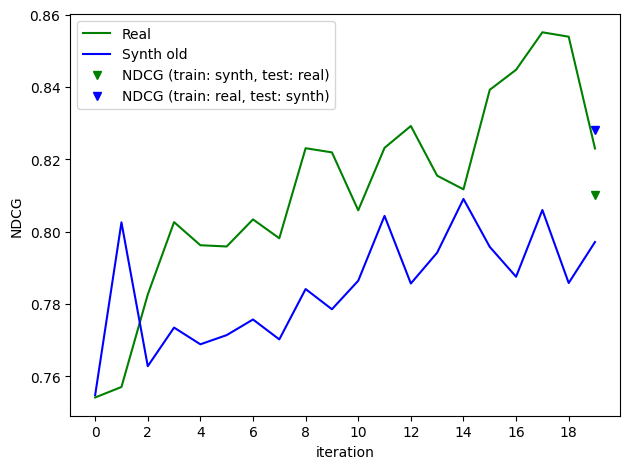

In [180]:
real_learning_metrics_pdf = pd.DataFrame(real_learning_metrics)
ucb_metrics_old_pdf = pd.DataFrame(ucb_metrics_old)

plt.plot(real_learning_metrics_pdf['NDCG@10'], color='g', label='Real')
plt.plot(ucb_metrics_old_pdf['NDCG@10'], color='b', label='Synth old')
plt.plot(19, real_metrics_trained_on_synth['NDCG@10'], 'gv', label='NDCG (train: synth, test: real)')
plt.plot(19, synth_metrics_trained_on_real['NDCG@10'], 'bv', label='NDCG (train: real, test: synth)')

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.legend()
plt.xticks(np.arange(0, 20, step=2.0))
plt.tight_layout()
#plt.savefig('val_qual_sber.png', dpi=300)

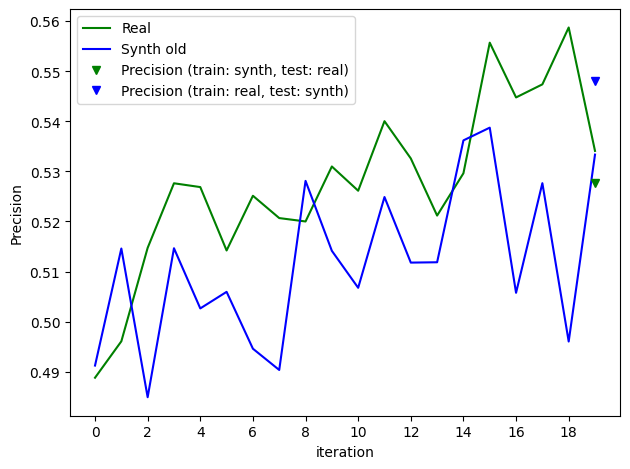

In [182]:
plt.plot(real_learning_metrics_pdf['Precision@10'], color='g', label='Real')
plt.plot(ucb_metrics_old_pdf['Precision@10'], color='b', label='Synth old')

plt.plot(19, real_metrics_trained_on_synth['Precision@10'], 'gv', label='Precision (train: synth, test: real)')
plt.plot(19, synth_metrics_trained_on_real['Precision@10'], 'bv', label='Precision (train: real, test: synth)')

plt.xlabel('iteration')
plt.ylabel('Precision')
plt.legend()
plt.xticks(np.arange(0, 20, step=2.0))
plt.tight_layout()

# Objective function optimization

In [ ]:
qco = QualityControlObjective(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    relevanceCol='relevance',
    response_function=pipeline,
    replay_metrics={NDCG() : 10, Precision() : 10}
)

LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)


DISC = 10
manifold = []
for a1 in range(DISC + 1):
    for a2 in range(DISC - a1 + 1):
        a3 = DISC - a1 - a2

        a_sum = a1 + a2 + a3
        manifold.append([a1 / a_sum, a2 / a_sum, a3 / a_sum])

obj = []
items_replay = synth_indexer.transform(items_df).cache()
for alphas in manifold:
    print(f'Current alpha : {alphas}')

    sim.clear_log()
    sim.log_filename = f'log_{"_".join([str(a) for a in alphas])}.parquet'
    resp_func.setWeights(alphas)

    for i in range(20):
        print(f'Stage {i}')
        start_iter = time.time()
        users = sim.sample_users(0.02).cache()

        log = sim.get_log(users)
        if log is None:
            log = empty_log
        log = log.cache()

        recs = simulator_model.predict(
            log=synth_indexer.transform(log),
            k=10,
            users=synth_indexer.transform(users),
            items=items_replay
        )
        recs = synth_indexer.inverse_transform(recs)

        true_resp = sim.sample_responses(
            recs_df=recs,
            user_features=users,
            item_features=items_df,
            action_models=pipeline
        ).select('user_id', 'item_id', 'relevance', 'response')

        sim.update_log(true_resp, iteration=i)

        simulator_model._clear_cache()
        train_log = sim.log.cache()
        simulator_model.fit(
            log=synth_indexer.transform(
                train_log.select('user_id', 'item_id', 'response')\
                         .withColumnRenamed('response', 'relevance')
            )
        )

        users.unpersist()
        if log is not None:
            log.unpersist()
        train_log.unpersist()
        end_iter = time.time()
        print(f"Time of {i} iteration: ")
        print(end_iter - start_iter)

    users = sim.sample_users(0.02)
    synth_recs = synth_indexer.inverse_transform(
        simulator_model.predict(
            log=synth_indexer.transform(sim.log),
            k=10,
            users=synth_indexer.transform(users),
            items=items_replay
        )
    )
    synth_ground_truth = sim.sample_responses(
        recs_df=synth_recs,
        user_features=users,
        item_features=items_df,
        action_models=pipeline
    ).select('user_id', 'item_id', 'response')\
     .withColumnRenamed('response', 'relevance')\
     .filter(sf.col('relevance') == 1)
    
    obj.append(
        qco(
            test_log=history_df_train,
            user_features=users_df,
            item_features=items_df,
            real_recs=real_recs,
            real_ground_truth=real_ground_truth,
            synthetic_recs=synth_recs,
            synthetic_ground_truth=synth_ground_truth
        )
    )

Current alpha : [0.0, 0.0, 1.0]
Stage 0


Time of 0 iteration: 
12.35241985321045
Stage 1


Time of 1 iteration: 
11.510929822921753
Stage 2


Time of 2 iteration: 
8.871090412139893
Stage 3
Time of 3 iteration: 
8.987804412841797
Stage 4


Time of 4 iteration: 
8.880954027175903
Stage 5


Time of 5 iteration: 
9.940253019332886
Stage 6
Time of 6 iteration: 
10.46973443031311
Stage 7


Time of 7 iteration: 
10.074403762817383
Stage 8


Time of 8 iteration: 
9.250143051147461
Stage 9


Time of 9 iteration: 
10.471828937530518
Stage 10


Time of 10 iteration: 
10.816314697265625
Stage 11
Time of 11 iteration: 
9.546218872070312
Stage 12


Time of 12 iteration: 
9.896090507507324
Stage 13


Time of 13 iteration: 
11.078615188598633
Stage 14


Time of 14 iteration: 
10.33514952659607
Stage 15


Time of 15 iteration: 
10.143929958343506
Stage 16


Time of 16 iteration: 
11.070913076400757
Stage 17


Time of 17 iteration: 
10.106784343719482
Stage 18


Time of 18 iteration: 
9.600978374481201
Stage 19


Time of 19 iteration: 
10.410096645355225


Current alpha : [0.0, 0.1, 0.9]
Stage 0


Time of 0 iteration: 
19.787757635116577
Stage 1


Time of 1 iteration: 
10.228794574737549
Stage 2


Time of 2 iteration: 
10.548052787780762
Stage 3


Time of 3 iteration: 
11.501298904418945
Stage 4


Time of 4 iteration: 
11.62491512298584
Stage 5


Time of 5 iteration: 
10.269901990890503
Stage 6


Time of 6 iteration: 
10.774733781814575
Stage 7


Time of 7 iteration: 
18.809592485427856
Stage 8


Time of 8 iteration: 
24.917052507400513
Stage 9


Time of 9 iteration: 
10.674290657043457
Stage 10


Time of 10 iteration: 
11.119681119918823
Stage 11


Time of 11 iteration: 
10.02995252609253
Stage 12


Time of 12 iteration: 
9.825921058654785
Stage 13


Time of 13 iteration: 
10.096710681915283
Stage 14


Time of 14 iteration: 
11.603918075561523
Stage 15


Time of 15 iteration: 
10.389782667160034
Stage 16


Time of 16 iteration: 
10.286679744720459
Stage 17


Time of 17 iteration: 
11.319008350372314
Stage 18


Time of 18 iteration: 
10.62083625793457
Stage 19


Time of 19 iteration: 
11.042814254760742


Current alpha : [0.0, 0.2, 0.8]
Stage 0
Time of 0 iteration: 
8.80301308631897
Stage 1


Time of 1 iteration: 
10.76414155960083
Stage 2


Time of 2 iteration: 
10.925821542739868
Stage 3


Time of 3 iteration: 
10.195529222488403
Stage 4
Time of 4 iteration: 
9.310442447662354
Stage 5


Time of 5 iteration: 
10.261688470840454
Stage 6
Time of 6 iteration: 
8.51612663269043
Stage 7


Time of 7 iteration: 
9.545380353927612
Stage 8


Time of 8 iteration: 
9.515691757202148
Stage 9


Time of 9 iteration: 
11.123401165008545
Stage 10


Time of 10 iteration: 
10.492473602294922
Stage 11


Time of 11 iteration: 
10.614847898483276
Stage 12


Time of 12 iteration: 
9.812597751617432
Stage 13


Time of 13 iteration: 
11.487894773483276
Stage 14


Time of 14 iteration: 
9.850026607513428
Stage 15


Time of 15 iteration: 
9.648193597793579
Stage 16
Time of 16 iteration: 
9.405424118041992
Stage 17


Time of 17 iteration: 
9.421717166900635
Stage 18


Time of 18 iteration: 
9.822469234466553
Stage 19


Time of 19 iteration: 
9.848103046417236


Current alpha : [0.0, 0.3, 0.7]
Stage 0
Time of 0 iteration: 
8.653762102127075
Stage 1


Time of 1 iteration: 
9.186483144760132
Stage 2


Time of 2 iteration: 
10.53019905090332
Stage 3


Time of 3 iteration: 
9.681738138198853
Stage 4


Time of 4 iteration: 
10.207595825195312
Stage 5


Time of 5 iteration: 
9.792607069015503
Stage 6


Time of 6 iteration: 
10.229425191879272
Stage 7


Time of 7 iteration: 
10.660775661468506
Stage 8


Time of 8 iteration: 
10.739200830459595
Stage 9


Time of 9 iteration: 
10.566742181777954
Stage 10


Time of 10 iteration: 
10.473407745361328
Stage 11
Time of 11 iteration: 
10.548585891723633
Stage 12


Time of 12 iteration: 
10.856622695922852
Stage 13


Time of 13 iteration: 
10.980041742324829
Stage 14


Time of 14 iteration: 
11.172977685928345
Stage 15


Time of 15 iteration: 
11.483718872070312
Stage 16


Time of 16 iteration: 
11.309582233428955
Stage 17


Time of 17 iteration: 
10.74475646018982
Stage 18


Time of 18 iteration: 
10.588345050811768
Stage 19


Time of 19 iteration: 
11.798070192337036


Current alpha : [0.0, 0.4, 0.6]
Stage 0


Time of 0 iteration: 
9.34427785873413
Stage 1


Time of 1 iteration: 
11.892688989639282
Stage 2


Time of 2 iteration: 
10.896308898925781
Stage 3


Time of 3 iteration: 
11.450653791427612
Stage 4


Time of 4 iteration: 
11.135526895523071
Stage 5


Time of 5 iteration: 
11.03665828704834
Stage 6


Time of 6 iteration: 
11.262505292892456
Stage 7


Time of 7 iteration: 
12.254157304763794
Stage 8


Time of 8 iteration: 
10.500898122787476
Stage 9


Time of 9 iteration: 
11.78345274925232
Stage 10


Time of 10 iteration: 
12.523247957229614
Stage 11


Time of 11 iteration: 
11.44190502166748
Stage 12


Time of 12 iteration: 
11.581448078155518
Stage 13


Time of 13 iteration: 
13.09426999092102
Stage 14


Time of 14 iteration: 
12.32116174697876
Stage 15


Time of 15 iteration: 
12.402200937271118
Stage 16


Time of 16 iteration: 
13.770076274871826
Stage 17


Time of 17 iteration: 
12.757846355438232
Stage 18


Time of 18 iteration: 
11.97464108467102
Stage 19


Time of 19 iteration: 
11.993541479110718


In [105]:
res = pd.DataFrame(data=manifold, columns=['real', 'noise', 'heuristic'])
res['obj'] = obj

res.to_csv('val_quality_control_sber.csv', index=False)

In [106]:
res

,real,noise,heuristic,obj
0,0.0,0.0,1.0,1.606157
1,0.0,0.1,0.9,1.674708
2,0.0,0.2,0.8,1.223230
3,0.0,0.3,0.7,1.623779
4,0.0,0.4,0.6,1.272851
...,...,...,...,...
61,0.8,0.1,0.1,1.387222
62,0.8,0.2,0.0,1.388313
63,0.9,0.0,0.1,1.633768
64,0.9,0.1,0.0,1.282362


In [107]:
x_data = []
y_data = []
z_data = []
for index, row in res.iterrows():
    x_data.append(row["heuristic"])
    y_data.append(row["real"])
    z_data.append(row['obj'])

In [109]:
res[res['obj'] == res['obj'].max()]

,real,noise,heuristic,obj
47,0.5,0.2,0.3,1.703717


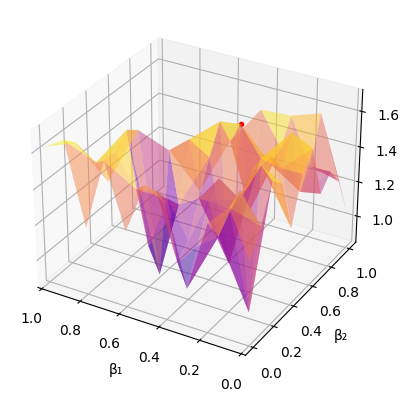

In [183]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
surf = ax.plot_trisurf(x_data, y_data, z_data, linewidth=0.1, alpha=0.5, color='g', cmap='plasma')

ax.set_xlabel("β₁")
ax.set_ylabel("β₂")
ax.set_xlim([1,0])

ax.plot(res[res['obj'] == res['obj'].max()]['heuristic'].values, 
           res[res['obj'] == res['obj'].max()]['real'].values, 
           [res['obj'].max()], c='r', marker='.')

plt.savefig('quality_control_sber.png', dpi=300)

Получается, что наилучшее качество функции отклика с точки зрения целевой функции достигается при следующих коэффициентах:
$$\beta_1=\hat{\alpha}_1=0.3 (Heur)$$
$$\beta_2=\hat{\alpha}_2=0.5 (Real)$$
$$\beta_3=\hat{\alpha}_3=0.2 (Random)$$

Теперь обучим рексистему в симуляторе с функцией отклика с подобранными параметрами.

In [135]:
sim_opt = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR3,
)

In [136]:
resp_func.setWeights([0.5, 0.2, 0.3])

ParametricResponseFunction_71cded664c4b

In [137]:
simulator_model = UCB(sample = True)

simulator_model.fit(log=synth_indexer.transform(history_df_train.drop('timestamp').limit(1)))

In [138]:
LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

items_replay = synth_indexer.transform(items_df).cache()

ucb_metrics = []

for i in range(20):
    iter_start = time.time()

    users = sim_opt.sample_users(0.02).cache()
    
    log = sim_opt.get_log(users)
    if log is None:
        log = empty_log
    log = log.cache()

    recs_ucb = simulator_model.predict(
        log=synth_indexer.transform(log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
    recs_ucb = synth_indexer.inverse_transform(recs_ucb).cache()

    resp_ucb = sim_opt.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items_df,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    sim_opt.update_log(resp_ucb, iteration=i)

    ucb_metrics.append(evaluator(resp_ucb))

    simulator_model._clear_cache()
    ucb_train_log = sim_opt.log.cache()
    simulator_model.fit(
        log=synth_indexer.transform(
            ucb_train_log\
                .select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    resp_ucb.unpersist()
    ucb_train_log.unpersist()

    print(f'Iteration {i} finished with time {time.time() - iter_start} sec.')
    
users = sim_opt.sample_users(0.2).cache()
synth_recs = synth_indexer.inverse_transform(
    simulator_model.predict(
        log=synth_indexer.transform(sim_opt.log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
).cache()
synth_ground_truth = sim_opt.sample_responses(
    recs_df=synth_recs,
    user_features=users,
    item_features=items_df,
    action_models=pipeline
).select('user_id', 'item_id', 'relevance', 'response').cache()
final_metrics_opt = evaluator(synth_ground_truth)

items_replay.unpersist()

Iteration 0 finished with time 23.50344157218933 sec.


Iteration 1 finished with time 13.233871936798096 sec.


Iteration 2 finished with time 12.707833051681519 sec.


Iteration 3 finished with time 13.319972038269043 sec.


Iteration 4 finished with time 13.428080320358276 sec.


Iteration 5 finished with time 13.122351884841919 sec.


Iteration 6 finished with time 14.29191780090332 sec.


Iteration 7 finished with time 14.23973536491394 sec.


Iteration 8 finished with time 13.849599599838257 sec.


Iteration 9 finished with time 15.591736078262329 sec.


Iteration 10 finished with time 13.316290378570557 sec.


Iteration 11 finished with time 12.47802186012268 sec.


Iteration 12 finished with time 13.126142024993896 sec.


Iteration 13 finished with time 19.30155038833618 sec.


Iteration 14 finished with time 12.708714962005615 sec.
Iteration 15 finished with time 12.762418270111084 sec.


Iteration 16 finished with time 12.339107751846313 sec.


Iteration 17 finished with time 12.853867292404175 sec.


Iteration 18 finished with time 13.102487087249756 sec.


Iteration 19 finished with time 16.917479753494263 sec.


DataFrame[item_attr_0: double, item_attr_1: double, item_attr_2: double, item_attr_3: double, item_attr_4: double, item_attr_5: double, item_attr_6: double, item_attr_7: double, item_attr_8: double, item_attr_9: double, item_attr_10: double, item_attr_11: double, item_attr_12: double, item_attr_13: double, item_attr_14: double, item_attr_15: double, item_attr_16: double, item_attr_17: double, item_attr_18: double, item_attr_19: double, item_attr_20: double, item_attr_21: double, item_attr_22: double, item_attr_23: double, item_attr_24: double, item_attr_25: double, item_attr_26: double, item_attr_27: double, item_attr_28: double, item_attr_29: double, item_attr_30: double, item_attr_31: double, item_attr_32: double, item_attr_33: double, item_attr_34: double, item_idx: int]

In [139]:
final_metrics_opt

{'NDCG@10': 0.8255619955885984,
 'Precision@10': 0.5364967188288738,
 'RocAuc@10': 0.5921267918239143}

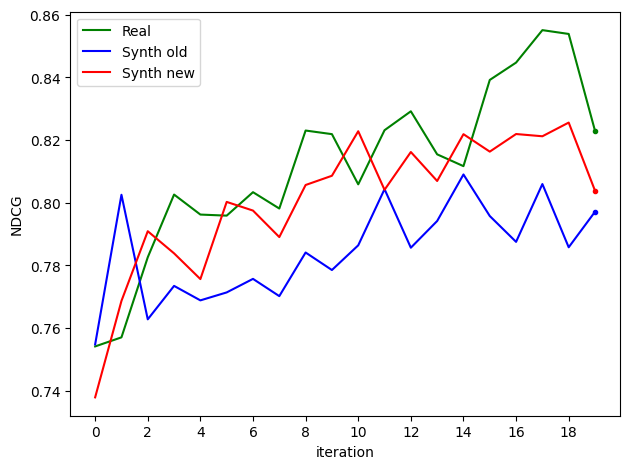

In [174]:
real_learning_metrics_pdf = pd.DataFrame(real_learning_metrics)
ucb_metrics_pdf = pd.DataFrame(ucb_metrics)
ucb_metrics_old_pdf = pd.DataFrame(ucb_metrics_old)
plt.plot(real_learning_metrics_pdf['NDCG@10'], color='g', label='Real')
plt.plot(ucb_metrics_old_pdf['NDCG@10'], color='b', label='Synth old')
plt.plot(ucb_metrics_pdf['NDCG@10'], color='r', label='Synth new')
plt.xlabel('iteration')
plt.ylabel('NDCG')

plt.plot(19, real_learning_metrics_pdf['NDCG@10'][19], 'g.')
plt.plot(19, ucb_metrics_old_pdf['NDCG@10'][19], 'b.')
plt.plot(19, ucb_metrics_pdf['NDCG@10'][19], 'r.')

plt.legend()
plt.xticks(np.arange(0, 20, step=2.0))
plt.tight_layout()

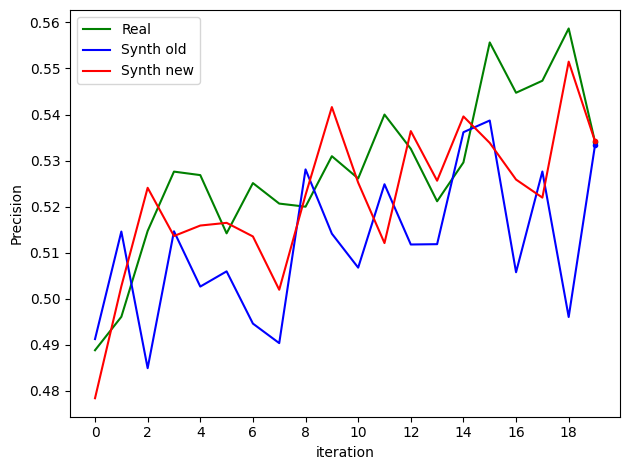

In [176]:
plt.plot(real_learning_metrics_pdf['Precision@10'], color='g', label='Real')
plt.plot(ucb_metrics_old_pdf['Precision@10'], color='b', label='Synth old')
plt.plot(ucb_metrics_pdf['Precision@10'], color='r', label='Synth new')
plt.xlabel('iteration')
plt.ylabel('Precision')

plt.plot(19, real_learning_metrics_pdf['Precision@10'][19], 'g.')
plt.plot(19, ucb_metrics_old_pdf['Precision@10'][19], 'b.')
plt.plot(19, ucb_metrics_pdf['Precision@10'][19], 'r.')

plt.legend()
plt.xticks(np.arange(0, 20, step=2.0))
plt.tight_layout()

Как видно из предыдущего графика, кривая обучения рекомендательной системы на новых синтетических данных (с оптимальными параметрами функции отклика) приблизилась к кривой обучения рекомендательной системы на синтетических данных.